## RL blood matching

<p> Start off using only the 3 major antigens: A,B and D. </p>

In [2]:
import pandas as pd
import numpy as np
import glob
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math

In [4]:
# Reads results csv files into df
def read_csv(path):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
    return full_df

In [81]:
# Separates and plots rewards
r_disc = -11 # reward for discarded product
def plot_reward(df, r_nex, title, lr = None):
    # Multiple number of nonexistent issues by r_nex
    reward_nex = r_nex * df['issued_but_nonexistent']
    # Reward for issued but discarded
    reward_disc = r_disc * df['issued_but_discarded']
    # Reward for outdated products
    reward_out = -1 * df['num_outdates']

    # Remaining reward
    reward_rem = df['reward'] - reward_disc - reward_nex - reward_out

    plt.plot(savgol_filter(reward_disc, window_length=200, polyorder=2), label='discarded')
    plt.plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='good')
    plt.plot(savgol_filter(reward_nex, window_length=200, polyorder=2), label='non existing')
    plt.plot(savgol_filter(reward_out, window_length=200, polyorder=2), label='outdates')

    plt.legend(loc="lower right")

    plt.xlabel('Days')
    plt.ylabel('Reward')
    plt.title(title)

    plt.show()

In [7]:
def plot_multi(dfs):

    r_nex = -50
    r_disc = -11

    cols = 2
    rows = math.ceil(len(dfs) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16,12))
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Reward non-existing
                reward_nex = r_nex * dfs[key]['issued_but_nonexistent']
                # Reward for issued but discarded
                reward_disc = r_disc * dfs[key]['issued_but_discarded']

                # Remaining reward
                reward_rem = dfs[key]['reward'] - reward_disc - reward_nex

                axes[i][j].plot(savgol_filter(reward_disc, window_length=200, polyorder=2), label='discarded')
                axes[i][j].plot(savgol_filter(reward_nex, window_length=200, polyorder=2), label='non-existing')
                axes[i][j].plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='good')
                axes[i][j].legend(loc = 'lower right')
                axes[i][j].set_title(dict_keys[l])
            l += 1

    plt.show()

In [8]:
def plot_satisfied(df, title):
    s = df['num_units_requested'] - df['issued_but_nonexistent'] - df['issued_but_discarded']
    r = df['num_units_requested']
    plt.plot(savgol_filter(s, window_length=200, polyorder=2), label='satisfied')
    plt.plot(savgol_filter(r, window_length=200, polyorder=2), label='requests')

    plt.legend(loc="lower right")

    plt.xlabel('Number units')
    plt.ylabel('Timesteps')

    plt.title(title)

    plt.show()
    return

### Network architecture
#### Input size

```
input_size = len(np.ravel(self.env.state))

# state dimension = 8 x 44
# 8:    number of blood groups
# 44:   max age (35) + max lead time (9)

input size = 8 * 44 = 352
```
#### Output size
```
output_size = self.env.action_space.shape[0]
# equal to number of actions: 8
```
#### Model
```
input -> [8, relu] -> [64, tanh] -> [32, tanh] -> [output, sigmoid]
```

### 1 Learning rate tests

Several tests with varying learning rates and the above NN architecture.
Reward for non-existing: -60.
Reward not compatible: -11.

Epsilon-decay applied each day: 0.995. Reset every episode.

Episode = 2 * 365
50 episodes.

In [85]:
path_a01 = r'results/request_scratch/learning_rates/a0.01'
path_a001 = r'results/request_scratch/learning_rates/a0.001'
path_a0001 = r'results/request_scratch/learning_rates/a0.0001'

a01 = read_csv(path_a01)
a001 = read_csv(path_a001)
a0001 = read_csv(path_a0001)

In [12]:
alphas = {'a0.01': a01, 'a0.001': a001, 'a0.0001':a0001}

In [83]:
plot_multi(alphas)

NameError: name 'alphas' is not defined

### 2 Epsilon decay test

Applied epsilon decay over all episodes as opposed to: within each episode and resetting the epsilon each time.
Decay set to 0.98.
Episode 25: 0.98<sup>25</sup> = 0.603.
Episode 45: 0.98<sup>45</sup> = 0.403

Time: 1:57:29.234508

#### Model
```
input -> [64, relu] -> [32, relu] -> [output, relu]
```
Note: accidentally used RELU activation for output..

Reward for non-existing products: -100
Reward not-compatible: -11.

Episode = 2 * 365
50 episodes.

In [16]:
path_ed098 = r'results/request_scratch/epsilon_decay/0.98'
ed098 = read_csv(path_ed098)

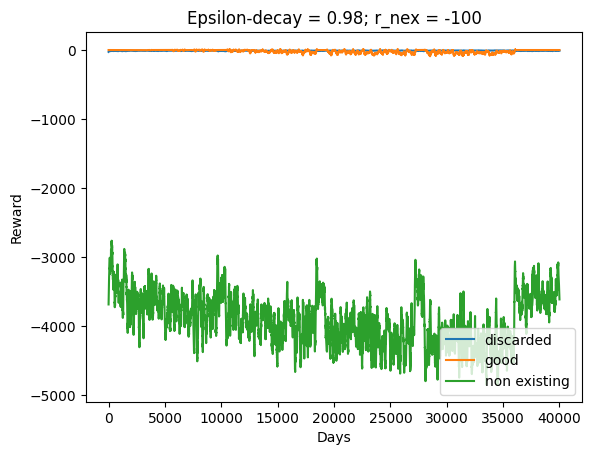

In [17]:
plot_reward(ed098, -100, 'Epsilon-decay = 0.98; r_nex = -100')

### 3 Reward shaping

Changed base reward to 50. Non-existing product, reward: -50.

Epsilon-decay over all episodes: 0.98 per episode.

#### Model
```
input -> [64, relu] -> [32, relu] -> [output, linear]
```
Episode = 5 * 365
100 episodes



In [19]:
reward_path = r'results/request_scratch/reward_50/64-32'
reward_df = read_csv(reward_path)

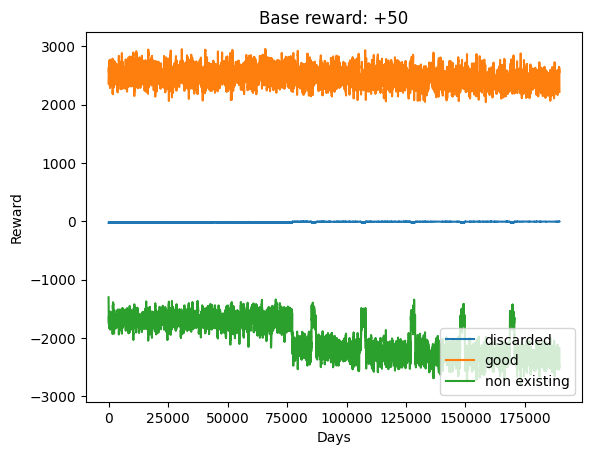

In [20]:
plot_reward(reward_df, -50, 'Base reward: +50')

### Smaller max age and lead time

Max age = 5
Lead time = 3

Episodes = 25
Episode = 2.5 year

alpha = 0.012480020972222375

[224, 32, 128]


In [84]:
path_5_3 = 'results/request_scratch/a0.012480020972222375_g0.5_b50/224_32_128'
a5_l3 = read_csv(path_5_3)

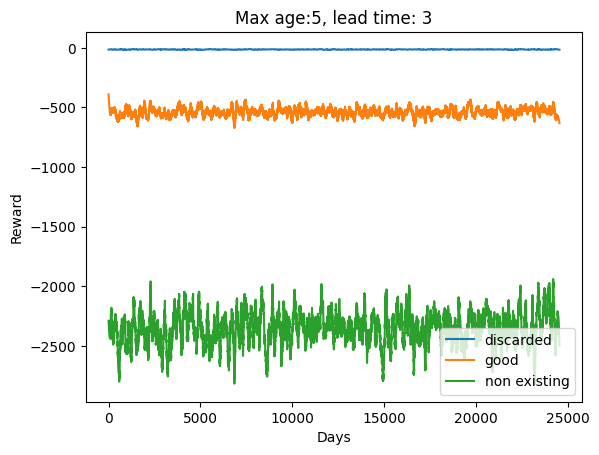

In [81]:
plot_reward(a5_l3, -60, 'Max age:5, lead time: 3')

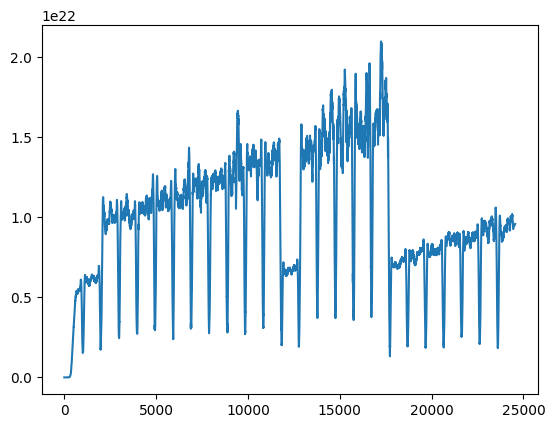

In [100]:
plt.plot(savgol_filter(a5_l3['day_loss'], window_length=200, polyorder=2), label='discarded')

In [76]:
path_new = 'results/request_scratch/a0.001_g0.5_b50/64_32'
df = read_csv(path_new)

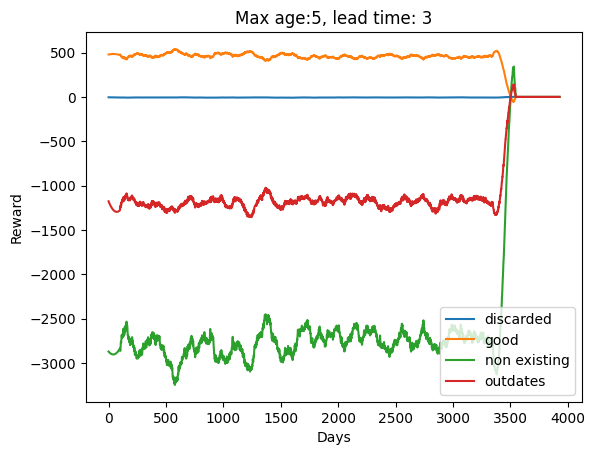

In [84]:
plot_reward(df, -60, 'Max age:5, lead time: 3')

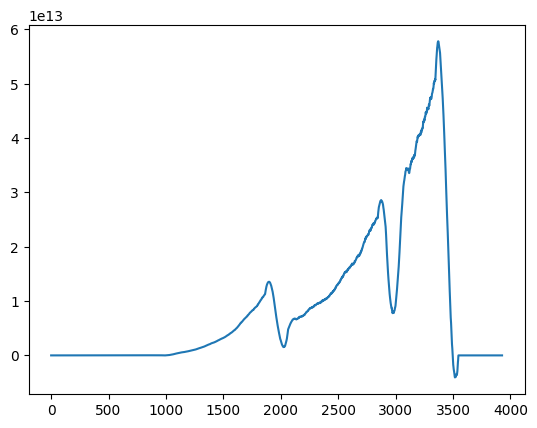

In [85]:
plt.plot(savgol_filter(df['day_loss'], window_length=200, polyorder=2), label='discarded')